In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import yaml

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Twitter API Keys
TWITTER_CONFIG_FILE = 'account1.yaml'

with open(TWITTER_CONFIG_FILE, 'r') as config_file:
    config = yaml.load(config_file)

consumer_key = config['twitter']['consumer_key']
consumer_secret = config['twitter']['consumer_secret']
access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Users
target_users = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@nytimes")

# Variables for holding sentiments
sentiments = []

for target_user in target_users:
    # Counter
    counter = 1

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(target_user, page=x)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Print Tweets
            # print("Tweet %s: %s" % (counter, tweet["text"]))

            # Run Vader Analysis on each tweet
            compound = analyzer.polarity_scores(tweet["text"])["compound"]
            pos = analyzer.polarity_scores(tweet["text"])["pos"]
            neu = analyzer.polarity_scores(tweet["text"])["neu"]
            neg = analyzer.polarity_scores(tweet["text"])["neg"]
            tweets_ago = counter
            
           
            # Add sentiments for each tweet into an array
            sentiments.append({"Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter,
                               "News Channel": target_user,
                              "Tweet": tweet["text"]})

            # Add to counter 
            counter = counter + 1

In [5]:
# Convert sentiments to DataFrame
sentiments_pd = pd.DataFrame.from_dict(sentiments)
sentiments_pd.head()
sentiments_pd.to_csv("news_mood.csv")

In [6]:
#Store Values of each media channel in a seperate DataFrame
sentiments_pd.set_index('News Channel', inplace=True)
nyt_df = sentiments_pd.loc['@nytimes']
bbc_df = sentiments_pd.loc['@BBC']
fox_df = sentiments_pd.loc['@FoxNews']
cnn_df = sentiments_pd.loc['@CNN']
cbs_df = sentiments_pd.loc['@CBS']

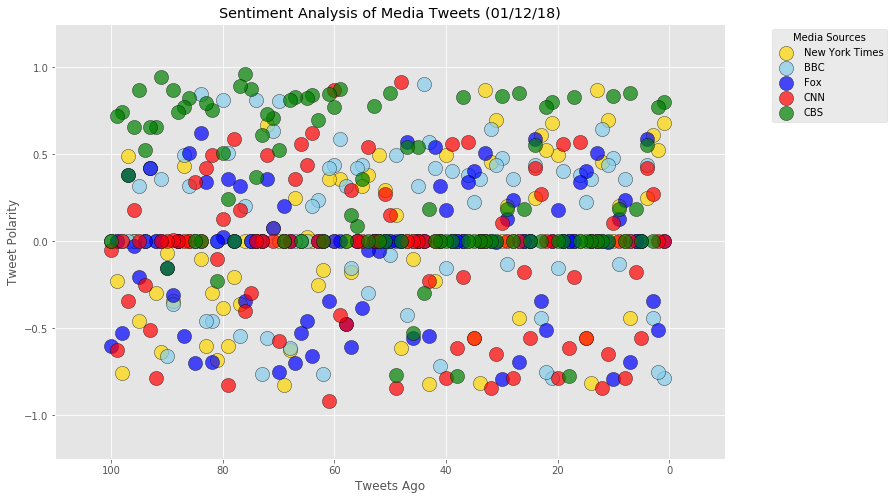

In [7]:
#Create Plot
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
nyt = plt.scatter(nyt_df['Tweets Ago'], nyt_df['Compound'], c = "gold", alpha=0.7, edgecolors="black", s=200)  
bbc = plt.scatter(bbc_df['Tweets Ago'], bbc_df['Compound'], c = "skyblue", alpha=0.7, edgecolors="black", s=200) 
fox = plt.scatter(fox_df['Tweets Ago'], fox_df['Compound'], c = "blue", alpha=0.7, edgecolors="black", s=200) 
cnn = plt.scatter(cnn_df['Tweets Ago'], cnn_df['Compound'], c = "red", alpha=0.7, edgecolors="black", s=200) 
cbs = plt.scatter(cbs_df['Tweets Ago'], cbs_df['Compound'], c = "green", alpha=0.7, edgecolors="black", s=200) 
plt.legend((nyt,bbc,fox,cnn,cbs),
           ("New York Times","BBC","Fox","CNN","CBS"),
           scatterpoints=1,
           bbox_to_anchor=(1.25, 1),
           loc='upper right',
          title="Media Sources")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.title("Sentiment Analysis of Media Tweets (%s)" % (time.strftime("%x")))
plt.ylim(-1.25,1.25)
plt.xlim(110,-10)
plt.savefig("Sentiment_Analysis_of_Media_Tweets.png")
plt.show()


In [8]:
# calculate overall media sentiment for each media ssource
sentiments_df = sentiments_pd.groupby("News Channel").mean()
sentiments_df.reset_index(inplace=True)
sentiments_df

,News Channel,Compound,Negative,Neutral,Positive,Tweets Ago
0,@BBC,0.084390,0.85399,0.06517,0.08086,50.5
1,@CBS,0.338734,0.82699,0.01755,0.15548,50.5
2,@CNN,-0.062517,0.86173,0.08161,0.05666,50.5
3,@FoxNews,-0.050552,0.84427,0.09112,0.06458,50.5
4,@nytimes,0.008956,0.85598,0.07051,0.07350,50.5


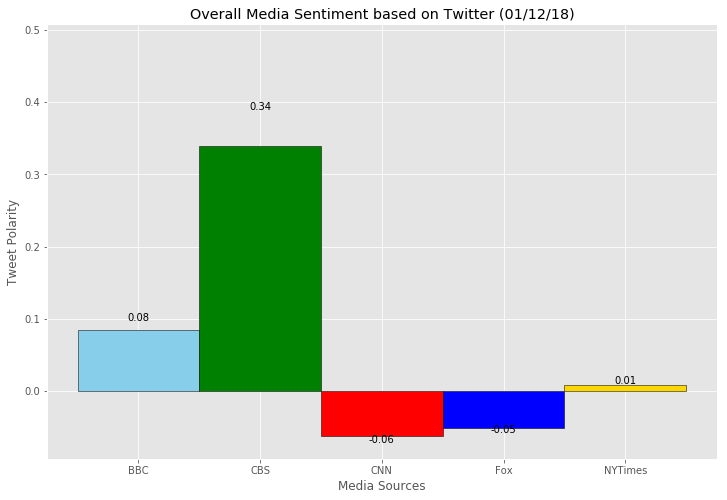

In [9]:
# define variables for graph
colors = ["skyblue", "green", "red","blue", "gold"]
edgecolor = ["black","black","black","black","black"]
xlabels = ["BBC", "CBS", "CNN", "Fox", "NYTimes"]
x = sentiments_df["News Channel"]
y = sentiments_df.Compound

#Create plot
plt.figure(figsize=(12,8))    
bars = plt.bar(x, y, width=1, color=colors, ec=edgecolor)

# Set the bar value on each bar
for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 1.15*height,
                '%s' % (str(float("{0:.2f}".format(height))) ),
                ha='center', color="black")
        
# set ylim for yaxis
ymax = max(sentiments_df.Compound)
ymin = min(sentiments_df.Compound)
if (ymax <0):
    ymax = -(ymax)
if (ymin >0):
    ymin = -(ymin)
plt.ylim(1.5*ymin, 1.5*ymax)
plt.xticks(np.arange(5),xlabels)
plt.title("Overall Media Sentiment based on Twitter (%s)" % (time.strftime("%x")))
plt.ylabel("Tweet Polarity")
plt.xlabel("Media Sources")
plt.savefig("Overall_Media_Sentiment.png")
plt.show()